# Fusion Chip Conversion Utility Example


<a href="https://colab.research.google.com/github/IBM/aihwkit/blob/master/notebooks/analog_fusion.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

## 1) Goal of the notebook
This is an example of how to convert the trained weights of the Anlaog hardware-aware trained LeNet5 model to conductance values in MicroSiemens and save the output to the specified file. The converted conductances can be programmed on the Analog Fusion chip using the [Analog Cloud Composer application](https://aihw-composer.draco.res.ibm.com).

Check out this [example notebook](https://github.com/IBM/aihwkit/blob/master/notebooks/tutorial/hw_aware_training.ipynb) for more details about Analog hardware-aware training using the [AIHWKIT](https://github.com/IBM/aihwkit).

## 2) Overview of the Fusion chip
The Fusion chip is a first-generation AI Analog chip by IBM Research. The chip has 512 word-lines (WL) and 2048 bit-lines. Each WL/BL address as a Phase Changed Memory (PCM) device in series with an access transistor that can be individually accessed. Therefore, there are 512x2048 or 1,048,576 PCM devices in total. This implies that the chip can hold neural networks with about 1 million weights. 
To learn more about the technology behind the IBM Fusion chip, check out this [blog](https://research.ibm.com/blog/the-hardware-behind-analog-ai). 

<div>
<center><img src="img/fusion-chip.png" width="500"/></center>
</div>





In [1]:
# Install the aihwkit and other needed libraries. 
# You can uncomment this section or parts of it if the libraries are installed in your environment. 
import os
return_code = os.system("which nvidia-smi")
#if torch.cuda.is_available():
if return_code == 0:
    DEVICE = 'cuda'
    !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl -P data
    !pip install data/aihwkit-0.9.0+cuda117-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    USE_CUDA = 1
else:
    DEVICE = 'cpu'
    !pip install aihwkit
    USE_CUDA = 0

!pip install matplotlib
!pip install mpl-scatter-density


/usr/bin/nvidia-smi


In [2]:
# Import prerequisites
import torch
import torch.nn as nn

In [3]:
# Imports from aihwkit.
from aihwkit.nn import AnalogConv2dMapped, AnalogLinearMapped, AnalogSequential
from aihwkit.simulator.presets.web import  WebComposerInferenceRPUConfig
from aihwkit.utils.legacy import convert_legacy_checkpoint
from aihwkit.utils.export import  fusion_export,  fusion_import
from aihwkit.inference.converter.fusion import FusionConductanceConverter
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.nn.modules.base import AnalogLayerBase
from aihwkit.simulator.configs.utils import WeightNoiseType, WeightClipType, WeightModifierType
from aihwkit.simulator.configs.utils import MappingParameter
from aihwkit.simulator.presets.utils import PresetIOParameters

In [4]:
# Sample code to print out the rpu_config that was used in the model.
def print_rpu_fields( model: nn.Module) -> None:
    """Print the Inference RPU Config fields"""

    print("\n>>> STARTING _print_rpu_fields() ")

    for name, module in model.named_modules():
        if not isinstance(module, AnalogLayerBase):
            continue

        print(f"RPUConfig of module {name}:")
        tile = next(module.analog_tiles())
        print(tile.rpu_config)
        print(tile.tile)
        print("-------------")
    print("\n>>> ENDING _print_rpu_fields() ")

In [5]:
# Create an Analog model.  In this example, create a LeNet5 model.  Note: replace it with your own model

N_CLASSES = 10
def create_analog_lenet5_network():

    """Returns a LeNet5 inspired analog model."""

    rpu_config = WebComposerInferenceRPUConfig()
    # print('rpu_config: ', rpu_config)
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2dMapped(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2dMapped(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinearMapped(in_features=channel[2], out_features=channel[3], rpu_config=rpu_config),
        nn.Tanh(),
        AnalogLinearMapped(in_features=channel[3], out_features=N_CLASSES, rpu_config=rpu_config),
        nn.LogSoftmax(dim=1)
    )

    return model


In [6]:
from torchvision import datasets, transforms

In [7]:
BATCH_SIZE = 8
N_CLASSES = 10
criterion = nn.CrossEntropyLoss()
PATH_DATASET = './data'

In [8]:
def load_images():
    """Load images for train from torchvision datasets."""
    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.FashionMNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.FashionMNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, validation_data

In [9]:
def run_inference(validation_data, model, criterion):
    """Validate the trained network
    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()
    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return epoch_loss, error, accuracy

In [10]:
# Download the example checkpoint file for LeNet5 model by uncomment the line below if you have not done that.
!wget https://github.com/IBM-AI-Hardware-Center/Composer/raw/main/hwa-trained-lenet5-mapped.pth -P data

In [11]:
# Prepare the model by loading the checkpoint. Note: replace with your data as applicable.
WEIGHT_PATH = 'data/hwa-trained-lenet5-mapped.pth'

model = create_analog_lenet5_network()

# Load the state dictionaries from the checkpoint file
state_dict = torch.load(WEIGHT_PATH, DEVICE)

# Convert the legacy checkpoint if the checkpoint was captured with the aihwkit version 0.7.1.  Otherwise you do not need to do the next step
state_dict, _ = convert_legacy_checkpoint(state_dict, model)

# load the state dictionaries to the model.
model.load_state_dict(state_dict)

<All keys matched successfully>

## Evaluate the model before applying the conductances read from the fusion chip.

In [12]:
_, validation_data = load_images()

if USE_CUDA:
        model.cuda()

_, error, accuracy = run_inference(validation_data, model, criterion)

print(f'Error after inference: {error:.2f}%\t'
      f'Accuracy after inference: {accuracy:.2f}%\t')

Error after inference: 9.67%	Accuracy after inference: 90.33%	


## Convert the weights in the model to conductance.  The conductance unit is MicroSiemens.

In [13]:
# Set the Gmax value.  The value must be between 10 and 40 inclusively
Gmax = 40
# Get the conductance converter for the fusion chip
g_converter=FusionConductanceConverter(Gmax)
# Convert the weights to conductance and write the data to the specified file name. NOTE: please change the name of the file as needed.
Target_csv = 'data/analog_lenet5.csv'
_, state_dict = fusion_export(model, file_name=Target_csv, g_converter=g_converter)

In [14]:
# Display the file by uncommenting out the line below.  NOTE: change the file name to your specified file name in the above step.
#!ls -l data/analog_lenet5.csv

## 2.1) Programming the conductances on Fusion Chip using Analog Composer 

After converting the neural network model weights to their equivalent conductance values, you can program these values on the Analog Fusion chip by submitting a custom fusion inference job using the [Composer application](https://aihw-composer.draco.res.ibm.com/). Follow the steps outlined in the figure below:

<center><img src="img/fusion-ui.png" width="1000"/></center>

## 2.2) Downloading the model data from the Fusion chip

After the inference job is completed, the programmed conductance values can be downloaded from the composer application in the form of CSV file. You can apply the programmed values to the model using fusion_import routine.

Below is an example of how to apply the programmed values obtained from the Fusion chip to your model.  

In [15]:
# There is a sample analog_fusion_lenet5.csv obtained from a Fusion inference job. 
!wget https://github.com/IBM-AI-Hardware-Center/Composer/raw/main/data/analog_fusion_lenet5.csv -P data

In [18]:
# Set the filename to the file that contains the programmed values.
Programmed_csv = 'data/analog_fusion_lenet5.csv' 

## 2.3) Using the fusion_import utility to set the model weights
This function imports the data from the Fusion chip and sets the model weights. Drift compensation is applied to the weights. 

In [20]:
# Import the programmed values to the model. 
programmed_model = fusion_import(Programmed_csv, model, state_dict=state_dict, g_converter=g_converter)

## Evaluate the model after applying the conductances read from the fusion chip.
You will notice the small difference between the accuracy for the initial model and the programmed model (model weights were read after one programming round on the Fusion chip). This shows that the algorithmic drift compensation technique that is used in AIHWKIT is helping recover the errors due to the noise that was introduced by the Analog Fusion chip. 

In [21]:
if USE_CUDA:
       programmed_model.cuda()
    
_, error, accuracy = run_inference(validation_data, programmed_model, criterion)

print(f'Error after inference: {error:.2f}%\t'
      f'Accuracy after inference: {accuracy:.2f}%\t')

Error after inference: 12.27%	Accuracy after inference: 87.73%	


## 2.5) Additional Analysis of the Conductance values 
### Plotting the Target and Programmed Conductance values
In what follows, Programmed refers to the conductance values read after programming the PCM chip. Target refers to the original conductance values. Conductances experience drift in PCM due to the Analog hardware non-idealities. Therefore, the read-programmed values are expected to drift from the target conductance values. 

In what follows, we will plot target vs. programmed conductance values and also plot the errors that were 

In [22]:
# Import the necessary python packages.
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

In [23]:
# Routine to convert the csv file to npy file for matplotlib plotting.
def convert_to_npy(csv_file: str, npy_file: str):
    one_list = []
    with open(csv_file) as f:
        for i, line in enumerate(f):
            if i < 6:
                continue
            elif i >= 6:
                actual_line = list((line.rstrip('\n')).split(','))
                one_list += actual_line
    f.close()
    one_array = array(one_list, dtype='float64')
    np.save(npy_file, one_array)

In [24]:
# Convert the Target and Programmed csv files to npy.
Target_npy = 'data/analog_lenet5.npy'
Programmed_npy = 'data/analog_fusion_lenet5.npy'
convert_to_npy(Target_csv, Target_npy)
convert_to_npy(Programmed_csv, Programmed_npy)

In [25]:
Target_array = np.load(Target_npy)
Programmed_array = np.load(Programmed_npy)

## Graph the Target and Programmed conductance values using a scatter plot with density.

/mnt/data/kvtran/miniconda/envs/colab/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/mnt/data/kvtran/miniconda/envs/colab/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


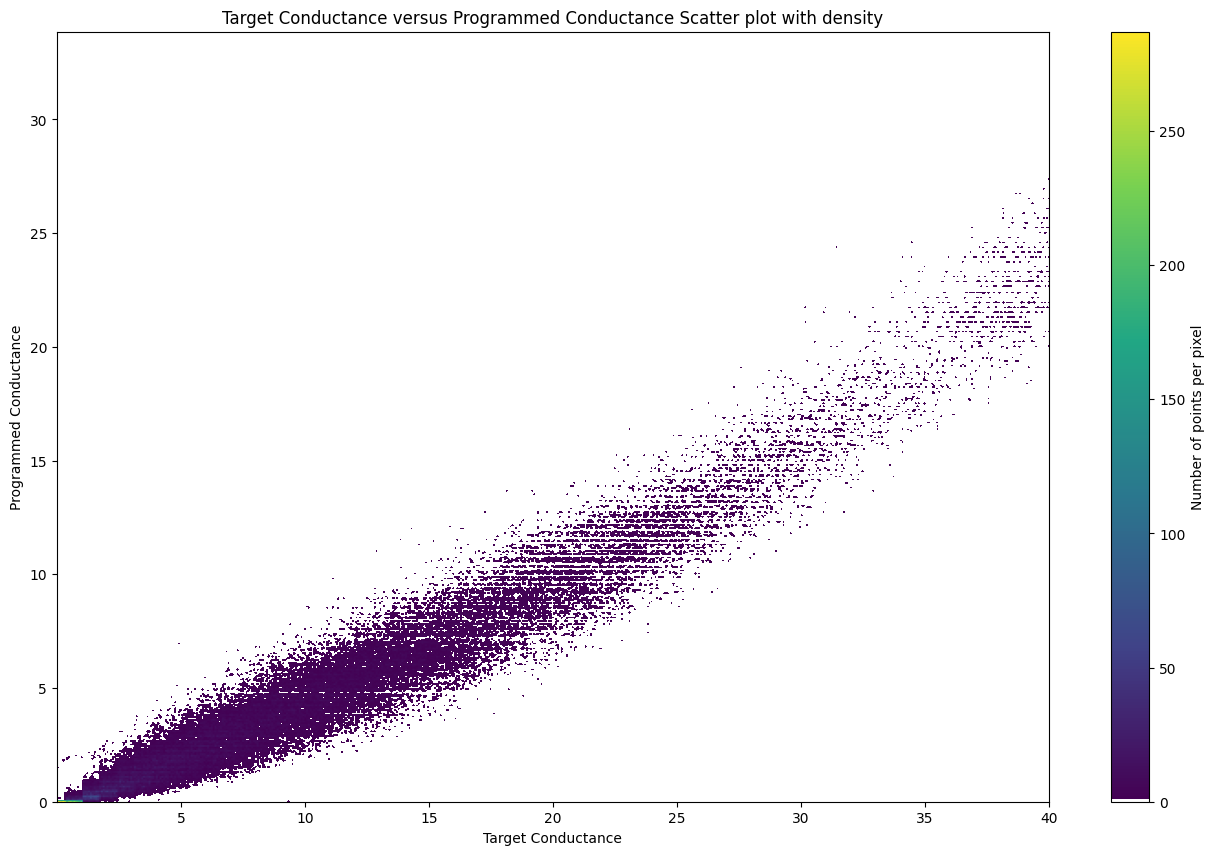

In [26]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# Code reused from https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure(figsize=(16, 10))
using_mpl_scatter_density(fig, Target_array, Programmed_array)
plt.xlabel('Target Conductance')
plt.ylabel('Programmed Conductance')
plt.title("Target Conductance versus Programmed Conductance Scatter plot with density")
plt.show()

## Plot the histogram for the Target and Programmed conductance values

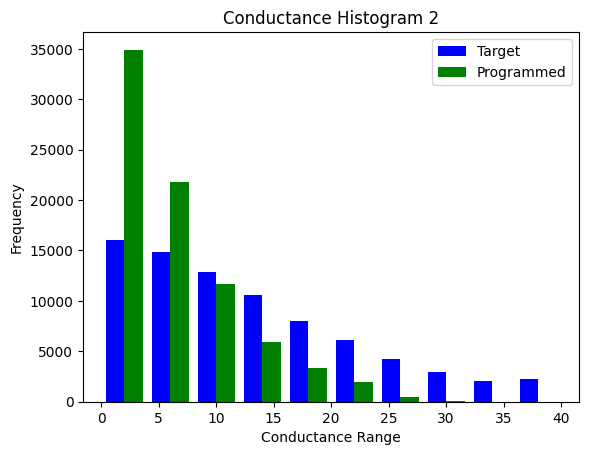

In [27]:
plt.hist([Target_array, Programmed_array], color=[
         'Blue', 'Green'], label=['Target', 'Programmed'])
plt.xlabel('Conductance Range')
plt.ylabel('Frequency')
plt.legend(['Target', 'Programmed'], loc='upper right')
plt.title("Conductance Histogram 2")
plt.show()

## Calculate the error between the Programmed and Target conductance and their standard deviation

In [28]:
TC_sum = sum(abs(Target_array))
PC_sum = sum(abs(Programmed_array))
# Calculate weight error by normalizing programmed conductance by (TC_sum / PC_sum) to account for conductance drift.
C_error = (100 * (Programmed_array * (TC_sum / PC_sum) - Target_array)) / Gmax

In [29]:
Std_err = np.std(C_error)

##  Plot the conductance errors between Target and Programmed

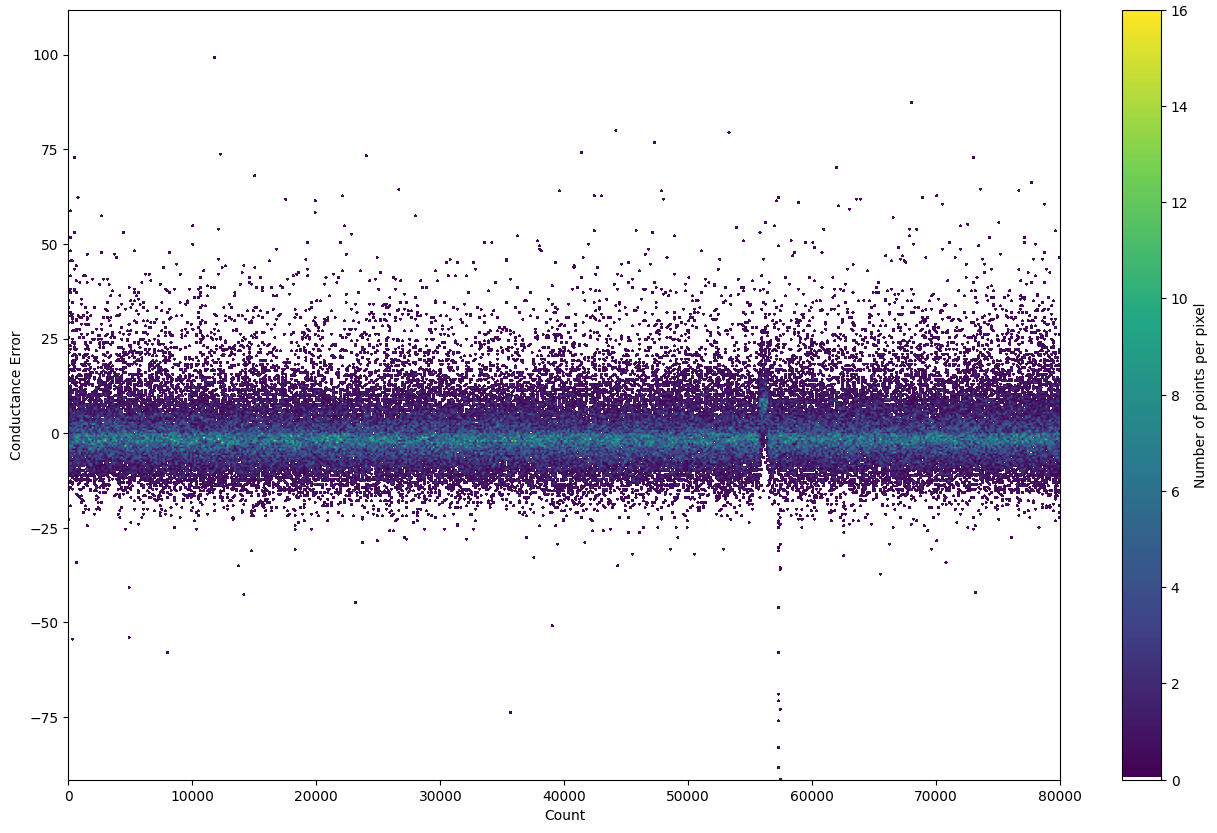

In [30]:
# Graph conductance error using Scatter plot with density
fig = plt.figure(figsize=(16, 10))
# fig = plt.figure()
x_axis = range(C_error.size)
using_mpl_scatter_density(fig, x_axis, C_error)
plt.ylabel('Conductance Error')
plt.xlabel('Count')
plt.show()


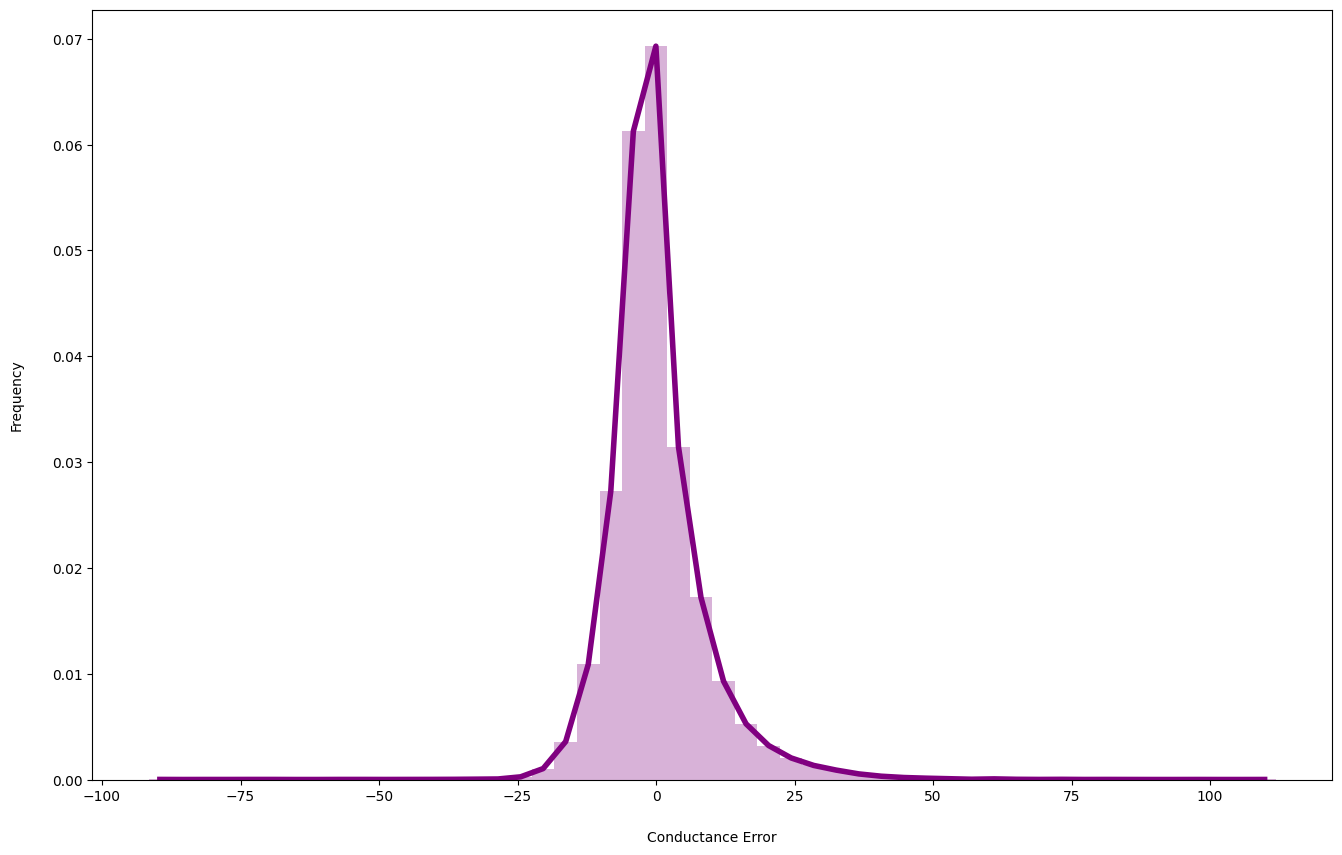

In [31]:
#Plot histogram of the Target vs. Programmed conductance errors

plt.figure(figsize=(16, 10))
# Code reused from https://stackoverflow.com/a/49389122
# Use matplotlib hist() instead of Seaborn histplot()  
# hist() returns info required to find points for line plot:
# 'n' - bin frequency (bar height)
# 'bins' - bin boundaries
n, bins, patches = plt.hist(
    x=C_error, 
    bins=50, 
    density=True,
    color="purple",
    alpha=0.3 # faded histogram 
)
# find bin midpoints
bin_centers = 0.5*(bins[1:]+bins[:-1])
# draw lines connecting successive points
plt.plot(bin_centers, n, linewidth=4, color="purple") 

plt.xlabel("Conductance Error", labelpad=20)
plt.ylabel("Frequency", labelpad=20)
plt.show()